In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import igraph
import warnings
warnings.filterwarnings('ignore')

In [4]:
ddir = "/home/scai/PhenPred/data/"
data_folder = "/home/scai/PhenPred/data/clines"

In [5]:
ss_cmp = pd.read_csv(f"{data_folder}/model_list_20230505.csv", index_col=0)

# Growth
growth = pd.read_csv(f"{data_folder}/growth_rate_20220907.csv")
growth = (
    growth.sort_values(["model_id", "replicates"], ascending=False)
    .groupby("model_id")
    .first()
)
growth = growth.dropna(subset=["day4_day1_ratio"])

In [6]:
cnv_measured = pd.read_csv(f"{data_folder}/cnv_summary_20230303_matrix.csv", index_col=0)

In [7]:
## CRISPR-Cas9
cas9_measured = pd.read_csv(
    f"{data_folder}/depmap23Q2/CRISPRGeneEffect.csv", index_col=0
)
cas9_measured.columns = cas9_measured.columns.str.split(" ").str[0]
# cas9_measured = scale(cas9_measured.T).T
cas9_measured = cas9_measured.rename(
    index=ss_cmp.reset_index().groupby("BROAD_ID").first()["model_id"]
)

In [8]:
measured_cnv_only = list(set(cnv_measured.index) - set(cas9_measured.index))
measured_cas9_only = list(set(cas9_measured.index) - set(cnv_measured.index))
measured_both = list(set(cnv_measured.index) & set(cas9_measured.index))

In [9]:
measured_groups = {
    "both": measured_both,
    "cnv_only": measured_cnv_only,
    "cas9_only": measured_cas9_only,
    "none": [],  # Will be automatically assigned for remaining samples
}

In [10]:
timestamp = "20250225_145621"
# Datasets - synthetic
## Transcriptomics
cnv_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_copynumber.csv.gz",
    index_col=0,
)

## CRISPR-Cas9
cas9_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_crisprcas9.csv.gz",
    index_col=0,
)

In [11]:
skew_df = pd.concat(
    [
        cas9_measured.apply(skew).astype(float).rename("skew_orig"),
        cas9_df.apply(skew).astype(float).rename("skew_mosa"),
    ],
    axis=1,
)


def build_string_ppi(score_thres=900):
    # ENSP map to gene symbol
    gmap = pd.read_csv(f"../data/ppi/9606.protein.aliases.v12.0.txt.gz", sep="\t")
    gmap = gmap[["BioMart_HUGO" in i.split(" ") for i in gmap["source"]]]
    gmap = gmap.groupby("#string_protein_id")["alias"].agg(lambda x: set(x)).to_dict()
    gmap = {k: list(gmap[k])[0] for k in gmap if len(gmap[k]) == 1}

    # Load String network
    net = pd.read_csv(f"../data/ppi/9606.protein.links.full.v12.0.txt.gz", sep=" ")

    # Filter by moderate confidence
    net = net[net["combined_score"] > score_thres]

    # Filter and map to gene symbol
    net = net[
        [p1 in gmap and p2 in gmap for p1, p2 in net[["protein1", "protein2"]].values]
    ]
    net["protein1"] = [gmap[p1] for p1 in net["protein1"]]
    net["protein2"] = [gmap[p2] for p2 in net["protein2"]]

    #  String network
    net_i = igraph.Graph(directed=False)

    # Initialise network lists
    edges = [(px, py) for px, py in net[["protein1", "protein2"]].values]
    vertices = list(set(net["protein1"]).union(net["protein2"]))

    # Add nodes
    net_i.add_vertices(vertices)

    # Add edges
    net_i.add_edges(edges)

    # Add edge attribute score
    net_i.es["score"] = list(net["combined_score"])

    # Simplify
    net_i = net_i.simplify(combine_edges="max")

    return net_i


ppi = build_string_ppi()


def ppi_dist_to_string(d, target_thres):
    if d == 0:
        res = "T"

    elif d == np.inf:
        res = "No link; No connection"

    elif d < target_thres:
        res = f"{int(d)}"

    else:
        res = f"{int(target_thres)}+"

    return res


def dist_crispr_gexp(crisprs, gexps, ppi):
    ppi_genes = set(ppi.vs["name"])
    genes = gexps.intersection(ppi_genes)
    assert len(genes) != 0, "No gexps overlapping with PPI provided"

    dmatrix = {
        c: dict(zip(*(genes, ppi.shortest_paths(source=c, target=genes)[0])))
        for c in crisprs
        if c in ppi_genes
    }

    return dmatrix


def ppi_annotation(df, ppi, target_thres=5):
    df_genes = set(df["x_id"])
    df_crispr = set(df["y_id"])

    # Calculate distance between gexp and crispr in PPI
    dist_d_g = dist_crispr_gexp(df_crispr, df_genes, ppi)

    # Annotate drug regressions
    def drug_gene_annot(c, g):
        if c == g:
            res = "T"

        elif c not in dist_d_g:
            res = "No link; CRISPR not in network"

        elif g not in dist_d_g[c]:
            res = "No link; Gene not in network"

        else:
            res = ppi_dist_to_string(dist_d_g[c][g], target_thres)

        return res

    df = df.assign(
        target_detailed=[drug_gene_annot(c, g) for c, g in df[["y_id", "x_id"]].values]
    )

    df = df.assign(
        target=["-" if t.startswith("No link;") else t for t in df["target_detailed"]]
    )

    return df

# pan-cancer level

In [10]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_copynumber_crisprcas9_popcorrected_latent.csv.gz"
)
df_res_vae["log10p_orig"] = -np.log10(df_res_vae["pval_orig"])
df_res_vae["log10p_vae"] = -np.log10(df_res_vae["pval_vae"])
df_res_vae['diff_log10p'] = df_res_vae['log10p_vae'] - df_res_vae['log10p_orig']
df_res_vae = df_res_vae.sort_values("diff_log10p", ascending=False)

In [11]:
df_res_vae_annot = pd.merge(df_res_vae, skew_df, left_on="y_id", right_index=True)
df_res_vae_annot = ppi_annotation(df_res_vae_annot, ppi)

In [12]:
df_res_vae_annot["log10fdr_orig"] = -np.log10(df_res_vae_annot["fdr_orig"])
df_res_vae_annot["log10fdr_vae"] = -np.log10(df_res_vae_annot["fdr_vae"])
df_res_vae_annot["diff_log10fdr"] = (
    df_res_vae_annot["log10fdr_vae"] - df_res_vae_annot["log10fdr_orig"]
)

In [13]:
df_res_vae_annot.to_csv(
    f"../reports/vae/crispr/{timestamp}_copynumber_crisprcas9_popcorrected_latent_annot.csv.gz",
    index=False,
)

In [12]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_copynumber_crisprcas9_popcorrected_latent_annot.csv.gz"
)

In [13]:
df_res_vae_filtered = df_res_vae_annot[df_res_vae_annot["beta_vae"].abs() > 0.05]
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 3")
# df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_orig < 2")
# df_res_vae_filtered = df_res_vae_filtered[
#     df_res_vae_filtered["target"].isin(["T", "1", "2", "3", "4", "5"])
# ]
# df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -2 and skew_mosa < -1.5")
COLS = [
    "y_id",
    "x_id",
    "beta_orig",
    "beta_vae",
    "fdr_orig",
    "fdr_vae",
    "diff_log10fdr",
    "skew_orig",
    "skew_mosa",
    "target",
]

In [17]:
df_res_vae_filtered.head()

,y_id,x_id,n_orig,beta_orig,lr_orig,covs_orig,pval_orig,fdr_orig,n_vae,beta_vae,...,log10p_orig,log10p_vae,diff_log10p,skew_orig,skew_mosa,target_detailed,target,log10fdr_orig,log10fdr_vae,diff_log10fdr
7,DDX5,FBLN1,737.0,0.066758,18.838555,212.0,1.422621e-05,0.019664,1532.0,0.052484,...,4.846911,8.782076,3.935165,-0.690885,-0.221135,3,3,1.706327,5.333215,3.626888
31,RAD51,HSP90AA1,737.0,-0.065628,17.468680,212.0,2.920801e-05,0.035098,1532.0,-0.052244,...,4.534498,7.907563,3.373065,-0.173114,-0.604592,2,2,1.454713,4.458702,3.003989
231,NMT1,MLLT10,737.0,0.067878,19.550272,212.0,9.798679e-06,0.040812,1532.0,0.051351,...,5.008832,7.672898,2.664066,-0.024690,-0.266524,No link; CRISPR not in network,-,1.389215,4.224037,2.834822
3170,YBX1,MUTYH,737.0,-0.091724,24.096664,212.0,9.161886e-07,0.003131,1532.0,-0.061018,...,6.038015,7.815478,1.777463,-0.406826,-0.833460,3,3,2.504268,4.366617,1.862348
52470,YBX1,MPL,737.0,-0.098511,33.561690,212.0,6.903920e-09,0.000059,1532.0,-0.063371,...,8.160904,9.060264,0.899359,-0.406826,-0.833460,3,3,4.229218,5.611403,1.382185


In [14]:
df_res_vae_filtered.shape

(38, 24)

In [18]:
df_res_vae_filtered[COLS].to_csv(
    f"../reports/vae/crispr/{timestamp}_copynumber_crisprcas9_pancancer_filtered_annot.csv",
    index=False,
)

In [14]:
df_res_vae_filtered = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_copynumber_crisprcas9_pancancer_filtered_annot.csv"
)

In [15]:
def plot_cnv_boxplot(
    cas9_name, cnv_name, measured_groups=None, tissue=None, model_list_df=None
):
    """
    Plot boxplots showing CRISPR-Cas9 effects for each copy number value.

    Parameters:
    -----------
    cas9_name: str
        Name of the CRISPR-Cas9 column
    cnv_name: str
        Name of the copy number column
    measured_groups: dict, optional
        Dictionary with keys: 'both', 'cnv_only', 'cas9_only', 'none'
        containing lists of sample IDs for each category
    tissue: str, optional
        Tissue type to filter for
    model_list_df: pd.DataFrame, optional
        DataFrame containing model metadata including tissue information
    """
    cas9 = cas9_df[cas9_name]
    cnv = cnv_df[cnv_name]

    if tissue is not None and model_list_df is not None:
        # Filter data by tissue
        model_list = model_list_df[model_list_df["tissue"] == tissue].index.values
        cas9 = cas9[cas9.index.isin(model_list)]
        cnv = cnv[cnv.index.isin(model_list)]

    # Merge data and get common samples
    df = pd.DataFrame({"CRISPR": cas9, "CNV": cnv})
    df = df.dropna()

    # Get the actual CNV values present in the data
    cnv_values = sorted(df["CNV"].unique())

    # Create figure
    plt.figure(figsize=(10, 6))

    if measured_groups is None:
        # Simple case: single boxplot for each CNV value
        sns.boxplot(data=df, x="CNV", y="CRISPR", color="lightgreen", order=cnv_values)

        # Add strip plot for individual points
        sns.stripplot(
            data=df,
            x="CNV",
            y="CRISPR",
            color="darkgreen",
            alpha=0.4,
            size=4,
            order=cnv_values,
            jitter=0.2,
        )

    else:
        # Complex case with measurement categories
        def get_category(idx):
            for cat in ["both", "cnv_only", "cas9_only"]:
                if idx in measured_groups[cat]:
                    return cat
            return "none"

        df["Category"] = df.index.map(get_category)

        # Count samples in each category
        category_counts = df["Category"].value_counts()

        # Create color and label mapping
        category_config = {
            "both": {
                "color": "green",
                "label": f"Both Measured (N={category_counts.get('both', 0)})",
            },
            "cnv_only": {
                "color": "blue",
                "label": f"CNV Only (N={category_counts.get('cnv_only', 0)})",
            },
            "cas9_only": {
                "color": "gray",
                "label": f"CRISPR Only (N={category_counts.get('cas9_only', 0)})",
            },
            "none": {
                "color": "red",
                "label": f"Both Imputed (N={category_counts.get('none', 0)})",
            },
        }

        # Create boxplot with hue for categories
        sns.boxplot(
            data=df,
            x="CNV",
            y="CRISPR",
            hue="Category",
            palette=[cfg["color"] for cfg in category_config.values()],
            order=cnv_values,
        )

        # Add strip plot for individual points
        sns.stripplot(
            data=df,
            x="CNV",
            y="CRISPR",
            hue="Category",
            palette=[cfg["color"] for cfg in category_config.values()],
            alpha=0.4,
            size=4,
            order=cnv_values,
            dodge=True,
            jitter=0.2,
        )

        # Update legend with sample counts
        handles, labels = plt.gca().get_legend_handles_labels()
        half = len(handles) // 2  # Because we have both boxplot and stripplot legends
        plt.legend(
            handles[:half],
            [category_config[cat]["label"] for cat in category_config],
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )

    # Add sample size annotations
    cnv_counts = df["CNV"].value_counts().sort_index()
    for i, count in enumerate(cnv_counts):
        plt.text(
            i,
            plt.ylim()[0],
            f"n={count}",
            horizontalalignment="center",
            verticalalignment="top",
        )

    # Calculate and annotate statistics
    try:
        kruskal_stat, kruskal_p = stats.kruskal(
            *[group["CRISPR"].values for name, group in df.groupby("CNV")]
        )

        plt.annotate(
            f"Kruskal-Wallis:\np = {kruskal_p:.2e}\nn = {len(df)}",
            xy=(0.02, 0.85),
            xycoords="axes fraction",
            bbox=dict(facecolor="white", alpha=0.8),
        )
    except ValueError:
        # Handle case where some groups might have too few samples
        print("Warning: Could not compute Kruskal-Wallis test.")

    # Labels and title
    plt.xlabel(f"{cnv_name} Copy Number")
    plt.ylabel(f"{cas9_name} CRISPR-Cas9 Effect")
    plt.grid(True, axis="y", alpha=0.3)

    title = f"{cas9_name} CRISPR-Cas9 Effect vs {cnv_name} Copy Number"
    if tissue is not None:
        title += f" ({tissue})"
    plt.title(title)

    # Adjust layout to prevent legend overlap
    if measured_groups is not None:
        plt.tight_layout()

    return plt.gca()

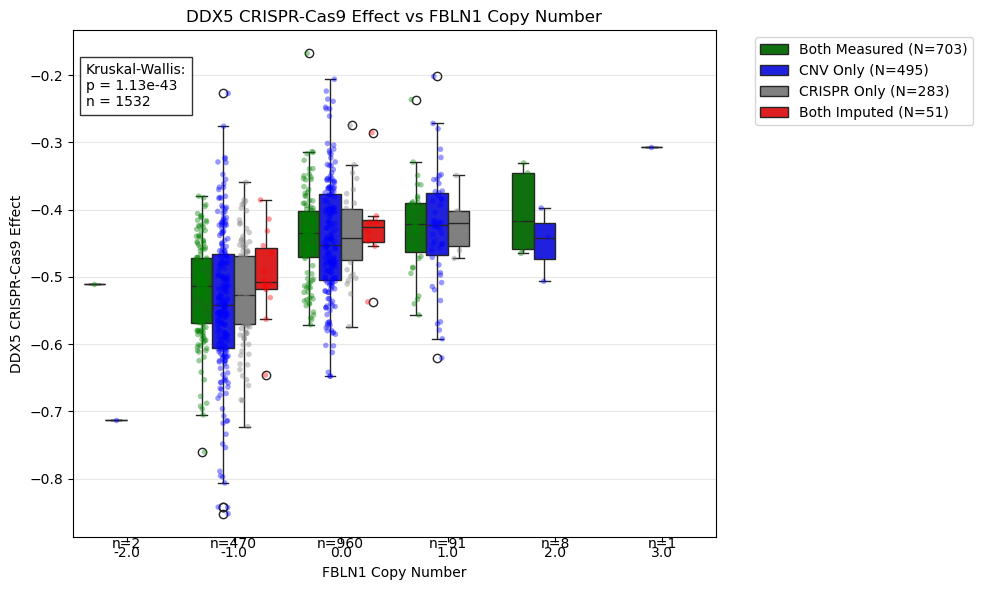

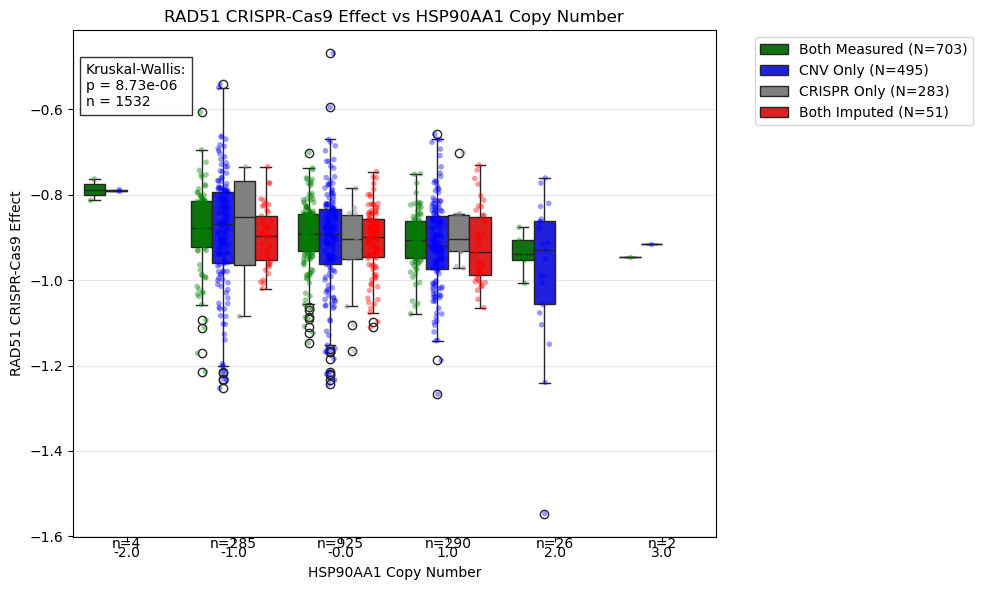

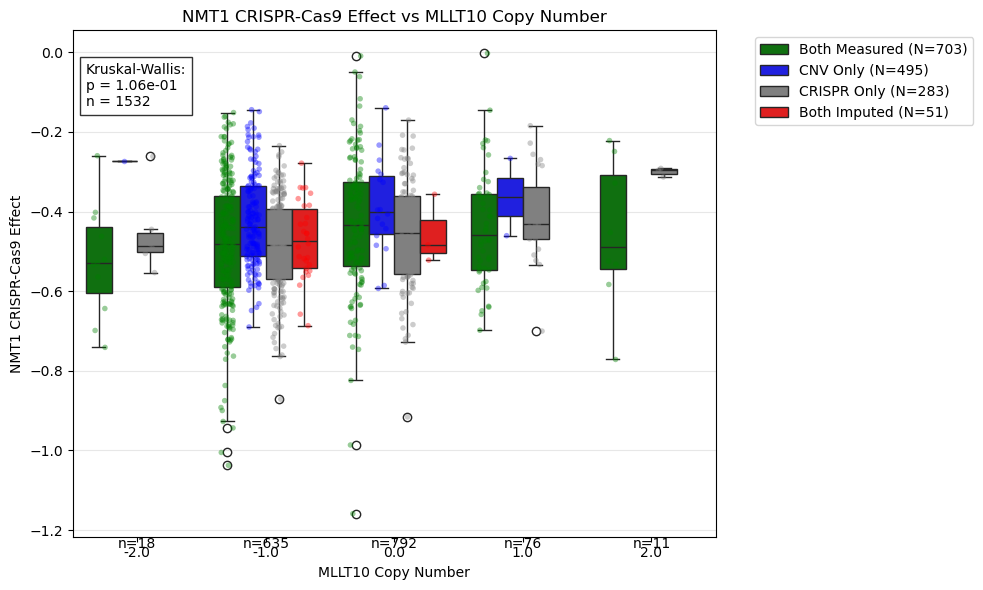

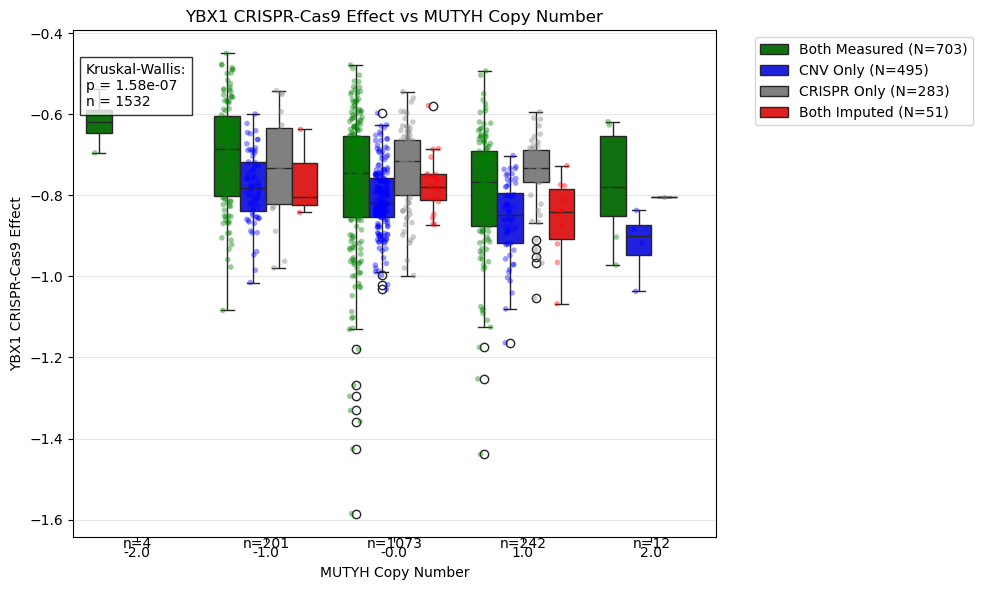

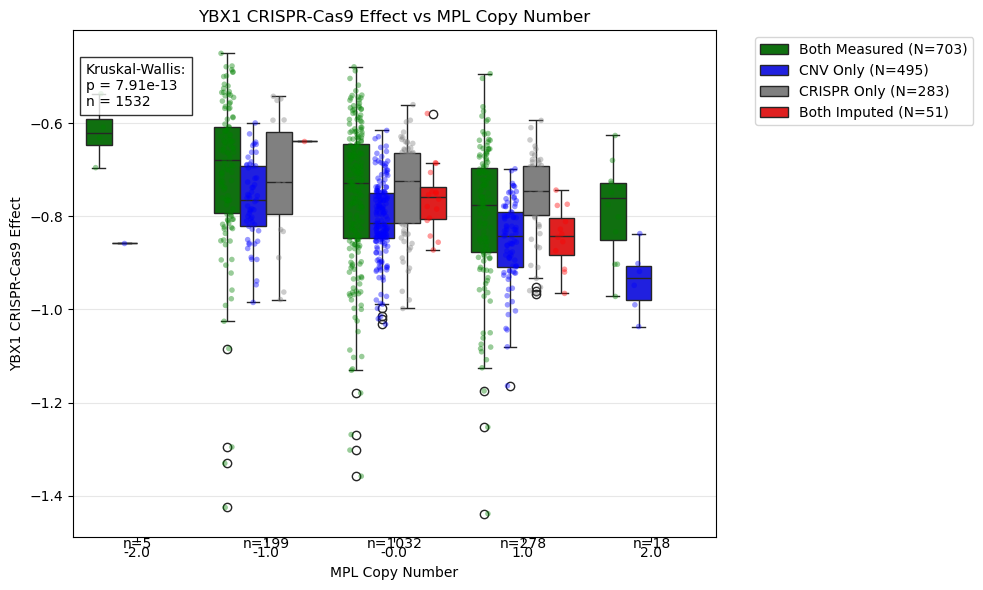

In [18]:
for row in df_res_vae_filtered[COLS].head(5).itertuples():
    plot_cnv_boxplot(
        row.y_id,
        row.x_id,
        measured_groups=measured_groups,
        model_list_df=ss_cmp,
    )